In [42]:
import pandas as pd
from geonamescache import GeonamesCache
from unidecode import unidecode
import re
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import DBSCAN
import matplotlib.patches as mpatches

In [43]:
def cluster_and_plot(data, epsilon, min_points):
    cluster_model = DBSCAN(eps=epsilon, 
                       min_samples=min_points,
                       #algorithm='ball_tree',
                       metric='haversine')
    headline_clusters = cluster_model.fit_predict(np.radians(data[['longitude', 'latitude']]))
    fig = plt.figure(figsize=(24, 16))
    map_plotter = Basemap()
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    map_plotter.scatter(data['longitude'],data['latitude'],latlon=True, c=headline_clusters)
    plt.show()
    return headline_clusters

In [44]:
def great_circle_distance(lat1, long1, lat2, long2):
    delta_phi = np.arccos(np.sin(np.radians(lat1))*np.sin(np.radians(lat2)) + 
                          np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.cos(np.abs(np.radians(long1)-np.radians(long2))))
    return 6371*delta_phi

In [45]:
def get_important_headlines(data, to_monitor):
    results = pd.DataFrame(columns = ['Disease', 'Latitude', 'Longitude', 'City', 'Headline'])
    for key in list(to_monitor.keys()):
        for epidemic in to_monitor[key]:
            temp = data[data['clusters']==epidemic]
            for row in temp.index: 
                match = re.search(key, temp.headline[row])
                if match != None:
                    results = results.append({'Disease':key, 'Latitude': temp.loc[row, 'latitude'], 
                                              "Longitude":temp.loc[row, 'longitude'], 'City':temp.loc[row,"city"], 
                                              "Headline":temp.loc[row, 'headline']}, ignore_index = True)
    return results          

In [46]:
data = pd.read_csv('Checkpoint03.csv', index_col = 0)
print(data.shape)
print(data.head())

(580, 7)
                                                        key         city  \
headline                                                                   
Authorities are Worried about the Spread of Nor...   292223        Dubai   
West Nile Virus Symptoms Spread all over Yerevan     616052      Yerevan   
Tuberculosis Hits Luanda                            2240449       Luanda   
Outbreak of Zika in Santa Elena                     3651438  Santa Elena   
Will Hepatitis B vaccine help La Paz?               3911925       La Paz   

                                                   country  population  \
headline                                                                 
Authorities are Worried about the Spread of Nor...      AE     2956587   
West Nile Virus Symptoms Spread all over Yerevan        AM     1093485   
Tuberculosis Hits Luanda                                AO     2776168   
Outbreak of Zika in Santa Elena                         EC       42214   
Will Hepatitis

In [47]:
usa_cases = data[data.country == 'US']
world_cases = data[data.country != 'US']
print(usa_cases.head())
print(world_cases.head())

                                                        key           city  \
headline                                                                     
Zika Virus Reaches San Francisco                    5391959  San Francisco   
Rumors about Hepatitis D spreading in Albany ha...  5106834         Albany   
Albany Residents Recieve Respiratory Syncytial ...  5106834         Albany   
Lower Hospitalization in Richmond after Mumps V...  4781708       Richmond   
Authorities are Worried about the Spread of Chi...  4781708       Richmond   

                                                   country  population  \
headline                                                                 
Zika Virus Reaches San Francisco                        US      864816   
Rumors about Hepatitis D spreading in Albany ha...      US       98469   
Albany Residents Recieve Respiratory Syncytial ...      US       98469   
Lower Hospitalization in Richmond after Mumps V...      US      220289   
Authoriti

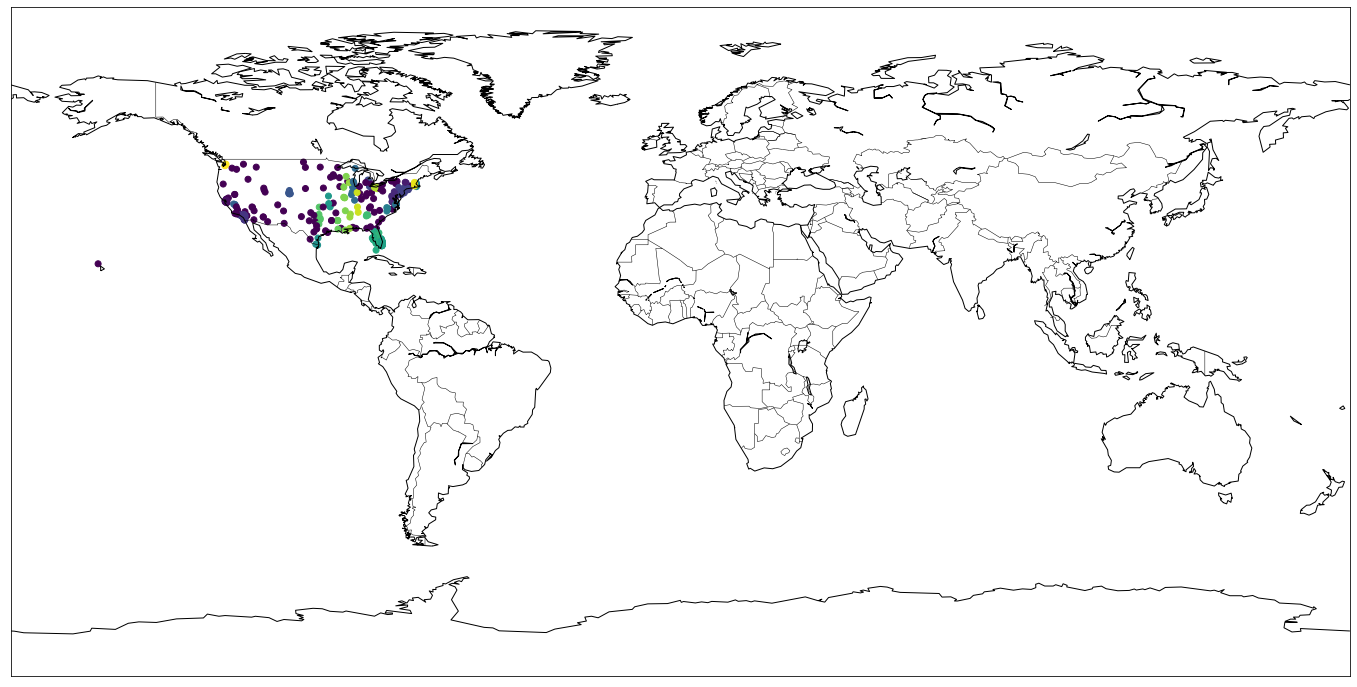

In [48]:
usa_clusters = cluster_and_plot(usa_cases, 0.006, 3)

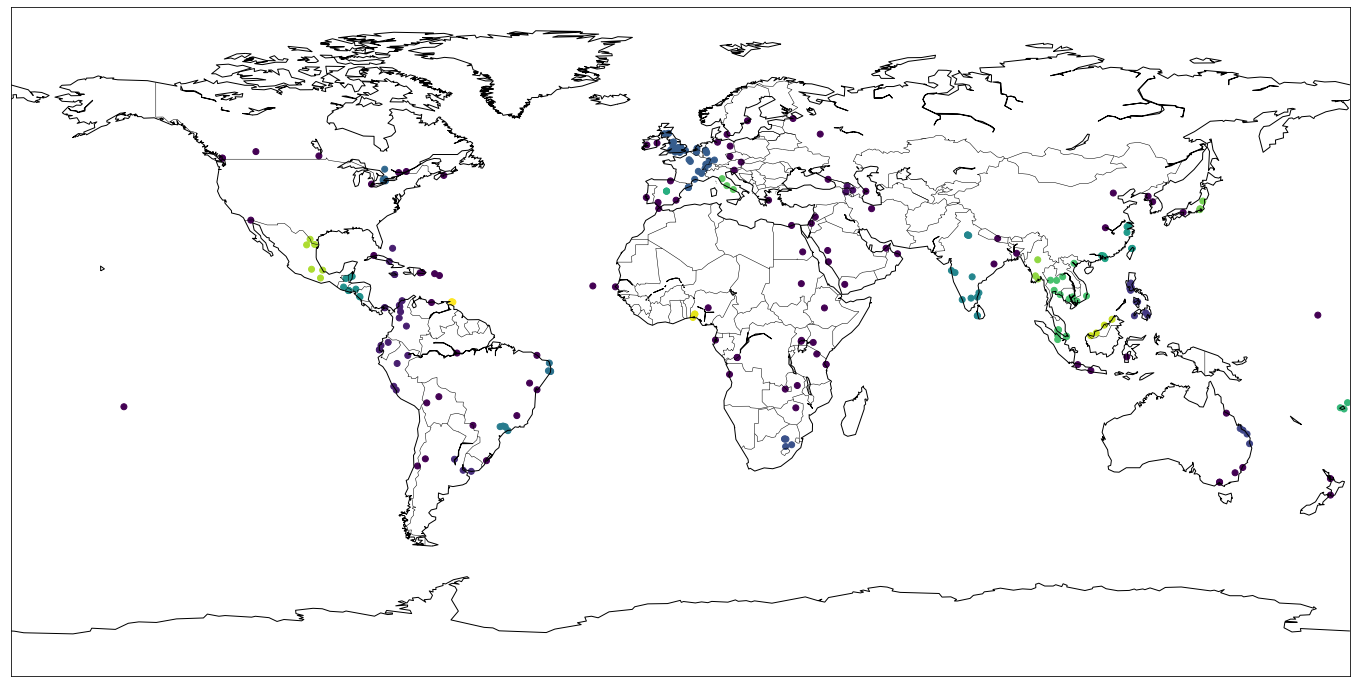

In [49]:
world_clusters = cluster_and_plot(world_cases, 0.05, 3)

In [50]:
usa_cases = usa_cases.reset_index()
usa_cases.drop(['country', 'clusters'], axis = 1, inplace = True)
usa_cases['clusters'] = usa_clusters
usa_cases.head()

,headline,key,city,population,latitude,longitude,clusters
0,Zika Virus Reaches San Francisco,5391959,San Francisco,864816,37.77493,-122.41942,0
1,Rumors about Hepatitis D spreading in Albany h...,5106834,Albany,98469,42.65258,-73.75623,1
2,Albany Residents Recieve Respiratory Syncytial...,5106834,Albany,98469,42.65258,-73.75623,1
3,Lower Hospitalization in Richmond after Mumps ...,4781708,Richmond,220289,37.55376,-77.46026,2
4,Authorities are Worried about the Spread of Ch...,4781708,Richmond,220289,37.55376,-77.46026,2


In [51]:
usa_cluster_order=usa_cases.groupby('clusters').count().sort_values(by='headline', ascending = False).index

In [52]:
us_outbreaks = {"Hepatitis B": [13], "Zika":[12,16,22,18,15,14], "Hepatitis A": [4], "Respiratory Syncytial Virus": [4], "Chlamydia": [4], "West Nile Virus": [4]}

In [53]:
usa_epidemics = get_important_headlines(usa_cases, us_outbreaks)

In [54]:
colors = {'Zika': 'Red', 'Chlamydia':'Yellow', 'Hepatitis A': 'Blue', 'Hepatitis B': 'Green', 'West Nile Virus': 'Orange', 'Respiratory Syncytial Virus':'Brown'}

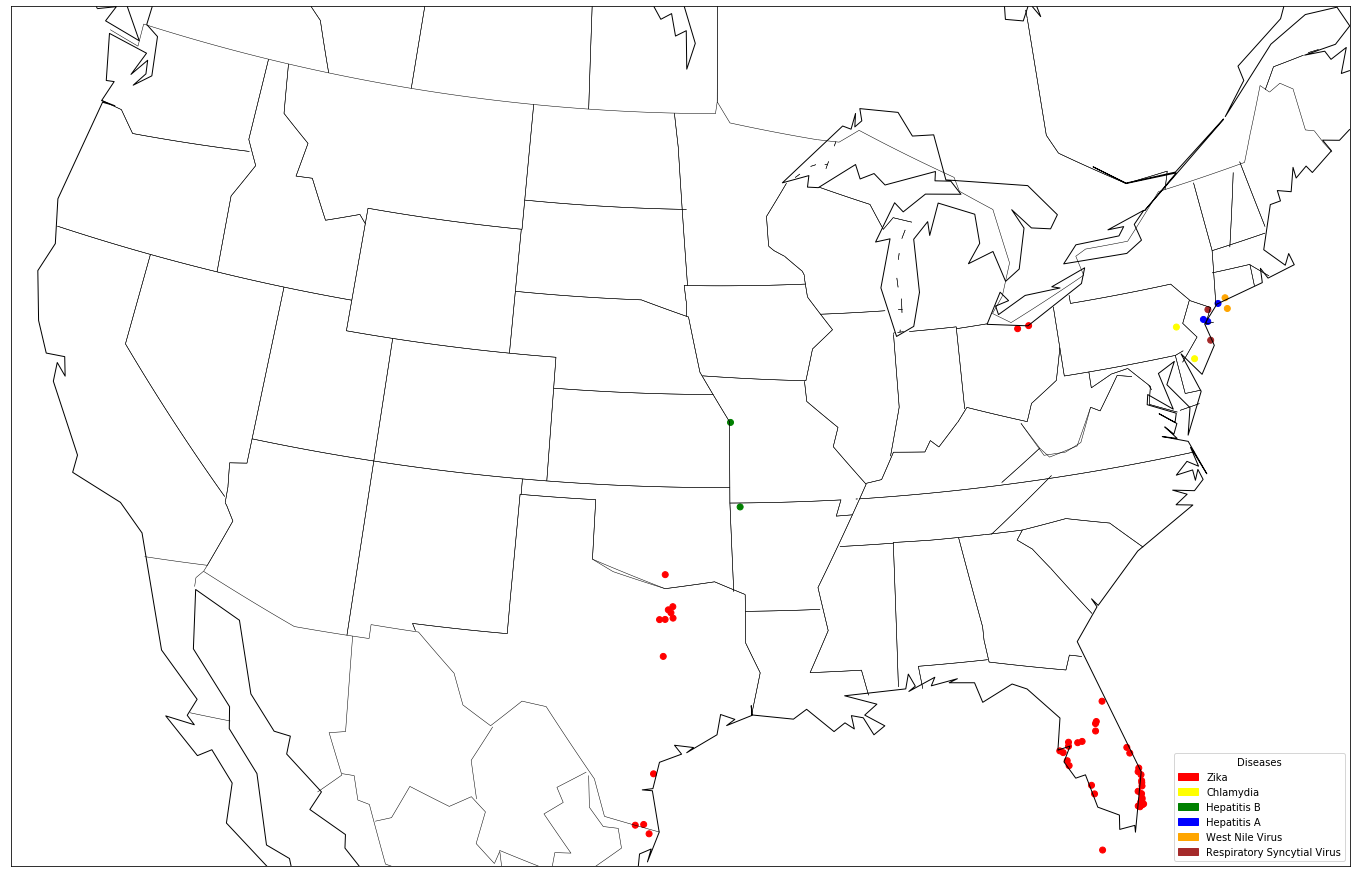

In [55]:
fig = plt.figure(figsize=(24, 16))
map_lcc = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
map_lcc.drawcoastlines()
map_lcc.drawcountries()
map_lcc.drawstates()
map_lcc.scatter(x = usa_epidemics['Longitude'].values, y = usa_epidemics['Latitude'].values,latlon=True, c = usa_epidemics['Disease'].map(colors))
lt = mpatches.Patch(color='Red', label='Zika')
ly = mpatches.Patch(color='Yellow', label='Chlamydia')
gt = mpatches.Patch(color='Green', label='Hepatitis B')
bl = mpatches.Patch(color='Blue', label='Hepatitis A')
og = mpatches.Patch(color='Orange', label='West Nile Virus')
br = mpatches.Patch(color='Brown', label='Respiratory Syncytial Virus')
plt.legend(handles=[lt,ly,gt,bl,og,br],title='Diseases', loc='lower right')
plt.show()

In [56]:
world_cases=world_cases.reset_index()
world_cases['clusters']=world_clusters
world_cases.head()

,headline,key,city,country,population,latitude,longitude,clusters
0,Authorities are Worried about the Spread of No...,292223,Dubai,AE,2956587,25.07725,55.30927,-1
1,West Nile Virus Symptoms Spread all over Yerevan,616052,Yerevan,AM,1093485,40.18111,44.51361,0
2,Tuberculosis Hits Luanda,2240449,Luanda,AO,2776168,-8.83682,13.23432,-1
3,Outbreak of Zika in Santa Elena,3651438,Santa Elena,EC,42214,-2.22622,-80.85873,1
4,Will Hepatitis B vaccine help La Paz?,3911925,La Paz,BO,812799,-16.50000,-68.15000,-1


In [57]:
world_cluster_order=world_cases.groupby('clusters').count().sort_values(by='headline', ascending = False).index

In [58]:
world_outbreaks={'Zika':[6, 1, 3, 8, 9, 11, 10, 3, 21], "Vericella":[22], "Varicella":[22], "Hepatitis B":[12], "Spanish Flu":[14], "Mad Cow Disease": [17,6]}

In [59]:
world_epidemics = get_important_headlines(world_cases, world_outbreaks)

In [60]:
colors = {'Zika': 'Red', 'Chlamydia':'Yellow', 
          'Hepatitis A': 'Blue', 'Hepatitis B': 'Green', 
          'West Nile Virus': 'Orange', 'Respiratory Syncytial Virus':'Brown',
         'Vericella':'grey', 'Varicella':'grey', 'Mad Cow Disease': 'gold',
         'Spanish Flu': 'cyan'}

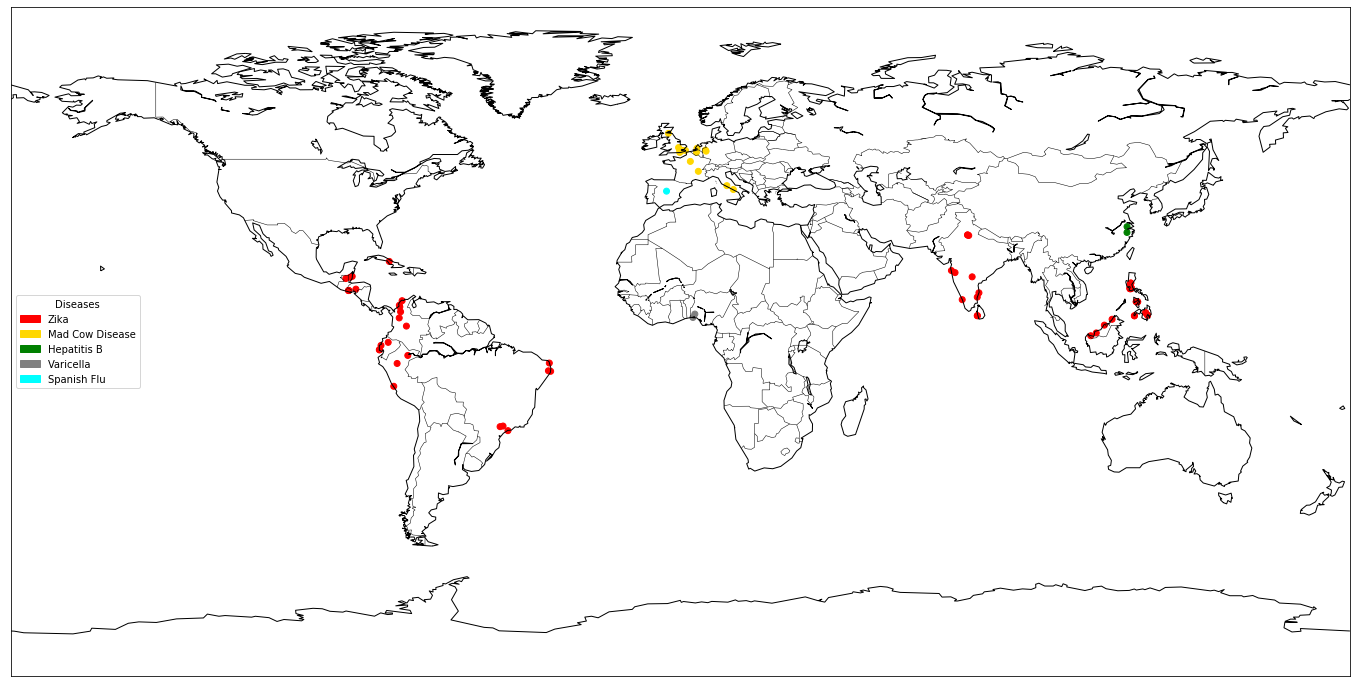

In [61]:
fig = plt.figure(figsize=(24, 16))
map_plotter = Basemap()
map_plotter.drawcoastlines()
map_plotter.drawcountries()
map_plotter.scatter(x = world_epidemics['Longitude'].values, y = world_epidemics['Latitude'].values,latlon=True, c = world_epidemics['Disease'].map(colors))
lt = mpatches.Patch(color='Red', label='Zika')
btwn = mpatches.Patch(color='gold', label='Mad Cow Disease')
gt = mpatches.Patch(color='Green', label='Hepatitis B')
gr = mpatches.Patch(color='grey', label='Varicella')
cy = mpatches.Patch(color='cyan', label='Spanish Flu')
plt.legend(handles=[lt,btwn,gt,gr,cy],title='Diseases', loc='center left')
plt.show()

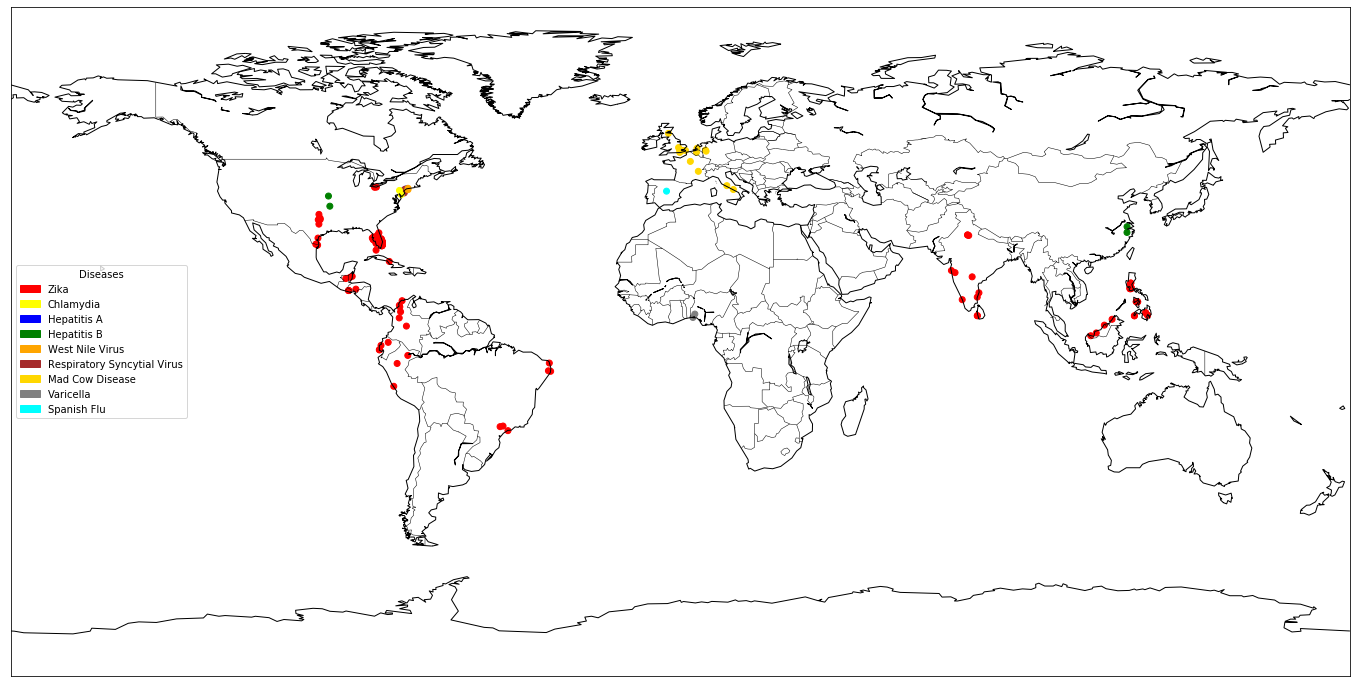

In [64]:
fig = plt.figure(figsize=(24, 16))
map_plotter = Basemap()
map_plotter.drawcoastlines()
map_plotter.drawcountries()
map_plotter.scatter(x = world_epidemics['Longitude'].values, y = world_epidemics['Latitude'].values,latlon=True, c = world_epidemics['Disease'].map(colors))
map_plotter.scatter(x = usa_epidemics['Longitude'].values, y = usa_epidemics['Latitude'].values,latlon=True, c = usa_epidemics['Disease'].map(colors))
lt = mpatches.Patch(color='Red', label='Zika')
ly = mpatches.Patch(color='Yellow', label='Chlamydia')
bl = mpatches.Patch(color='Blue', label='Hepatitis A')
gt = mpatches.Patch(color='Green', label='Hepatitis B')
og = mpatches.Patch(color='Orange', label='West Nile Virus')
br = mpatches.Patch(color='Brown', label='Respiratory Syncytial Virus')
btwn = mpatches.Patch(color='gold', label='Mad Cow Disease')
gr = mpatches.Patch(color='grey', label='Varicella')
cy = mpatches.Patch(color='cyan', label='Spanish Flu')
plt.legend(handles=[lt,ly, bl, gt, og, br, btwn, gr, cy],title='Diseases', loc='center left')
plt.show()